Update summary, in addition to updating the throughput of instruments and telescopes, this update fully incorporates the calculation method of AO coupling used by Ashley into PSIsim.

For the new AO mode, the new AO band magnitude acquisition function has been updated. The new function needs to input the AO filter, band, ao_booster and object temperature. In addition, AO module also added two parameters: ao_ho_wfe and ao_tt_dynamic. To get them we need to use "spectrum.ao_coupling"

For "spectrum.ao_coupling", we need to input: instrument, ao mode, ao filter, ao band, and ao band magnitude.

For the convenience of comparison, for the functions that need to be replaced, I keep all the functions used by the original PSIsim (except emissivity), on the other hand, I added the suffix "_newao" to the newly added functions.

Currently HISPEC is not available due to lack of necessary instrument data files. Once the file is obtained, the HISPEC module is ready to use.

First import all the things and setup the plot things

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import time
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from importlib import reload
import speclite.filters
from scipy.interpolate import interp1d, RegularGridInterpolator as rgi
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from scipy.signal import medfilt, correlate
from numpy.random import poisson, randn
import copy 
from psisim import datadir
from psisim import spectrum
import psisim.nair as nair
SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Tried importing picaso, but couldn't do it


/var/folders/6t/cpjtlkn10wv603vnph9nr3sh0000gn/T/ipykernel_4000/3990040308.py:10: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter


## Initial Setup

Setup the path to the peripheral files and load in the filter objects from speclite

In [2]:
#this needs to be modified
path = '/Users/huihaoz/Downloads/psisim-kpic/scr3/dmawet/ETC/'
filters = spectrum.load_filters()

## Telescope Setup

A *telescope* object contains the telecope parameters, the site characteristics and the current conditions. 

In [3]:
TMT = telescope.TMT(path=path)
TMT.airmass=1.2
TMT.water_vapor=1.5
TMT.seeing = TMT.median_seeing

## Instrument Setup

An _instrument_ object contains both the static instrument parameters, as well as the current observing setup

In [4]:
#Initialize a modhis object and set the current filter
modhis = instrument.modhis(telescope=TMT)
modhis.set_current_filter("TwoMASS-K")

#Get the set of wavelengths based on the current instrument setup
wavelengths = np.arange(0.5,2.5,1e-3)*u.um #modhis.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
modhis.set_observing_mode(3600*4,1,'TwoMASS-K', wavelengths,mode="off-axis", vortex_charge=1) 

MODHIS is mostly untested at this point


/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")


## Generate some Spectra

We can now generate a host spectrum

In [5]:
#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.5*u.dex(u.cm/ u.s**2),"StarTeff":2800*u.K,"StarZ":'-0.0',"StarAlpha":"0.0",
                   "StarRadialVelocity":0.001*u.km/u.s,
                    "StarVsini":0.001*u.km/u.s,
                    "StarLimbDarkening":0.001}

#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (path,'TwoMASS-K',14.0,filters,modhis.current_filter)

#Generate the spectrum! (Here we apply a doppler shift and rotationally broaden)
host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,modhis.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=modhis.current_dwvs)


In [6]:
obj_properties = {"StarLogg":3.25*u.dex(u.cm/ u.s**2),"StarTeff":700*u.K,"StarRadialVelocity":20*u.km/u.s,"StarVsini":10*u.km/u.s,
                  "StarLimbDarkening":0.9}

obj_user_params = (path,'TwoMASS-K',20,filters,modhis.current_filter)

obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,modhis.current_R,model="Sonora",
                                             user_params=obj_user_params,doppler_shift=True,broaden=True,
                                             delta_wv=modhis.current_dwvs)

## New code

### ao_booster

In [7]:
#input: mag of star, filter and band, Teff
f0 = spectrum.scale_stellar(14.0,'TwoMASS-K',2800*u.K,path=path)

### modhis ao parameters

In [8]:
# The angular separation of the companion, in milliarcsecond
host_properties['AngSep'] = 400 *u.mas

#Get the host star magnitude in the AO filter
host_properties["StarAOmag"] =spectrum.get_band_mag(family='Johnson',band='R',factor_0=f0,teff_s=2800*u.K,path=path)
#only johnson-R so far
modhis.ao_mag = spectrum.get_band_mag(family='Johnson',band='R',factor_0=f0,teff_s=2800*u.K,path=path)

modhis.ao_ho_wfe, modhis.ao_tt_dynamic = spectrum.ao_coupling(instrument='modhis',ao_mode='LGS_OFF',ao_filter='Johnson',ao_band_mag=modhis.ao_mag )

#modhis doesn't care about the spectral type, but we need to include the paramter
host_properties['StarSpT'] = None

In [9]:
modhis.ao_mag

18.138047931969222

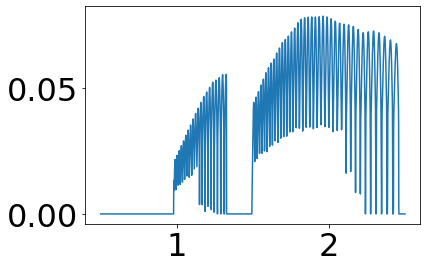

In [10]:
plt.plot(wavelengths,modhis.get_inst_throughput_newao(wvs=wavelengths))

# Because of the original PSISIM design considerations, we want the object spectrum in contrast units

In [11]:
obj_spectrum.spectrum

<Quantity [0.00000000e+00, 1.26436832e-12, 9.40784206e-13, ...,
           1.00921854e-07, 7.50292285e-08, 1.71935357e-07] ph / (Angstrom cm2 s)>

In [12]:
host_spectrum.spectrum

<Quantity [0.00000000e+00, 1.65314027e-06, 1.16294516e-06, ...,
           7.78799748e-05, 8.05307763e-05, 8.54070123e-05] ph / (Angstrom cm2 s)>

In [13]:
obj_spectrum.spectrum /= host_spectrum.spectrum

/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [14]:
obj_spectrum.spectrum

<Quantity [           nan, 7.64828210e-07, 8.08966955e-07, ...,
           1.29586398e-03, 9.31683909e-04, 2.01312928e-03]>

In [15]:
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation_newao(TMT,modhis,host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                       post_processing_gain = 10,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False)

/Users/huihaoz/Downloads/psisim-kpic/psisim/observation.py:603: RuntimeWarning: invalid value encountered in sqrt
  photon_noise = np.sqrt(detector_spectrum.decompose().value + thermal_spectrum.decompose().value + speckle_noise.decompose().value) * u.electron


Text(0, 0.5, 'Spectrum [electron um / micron]')

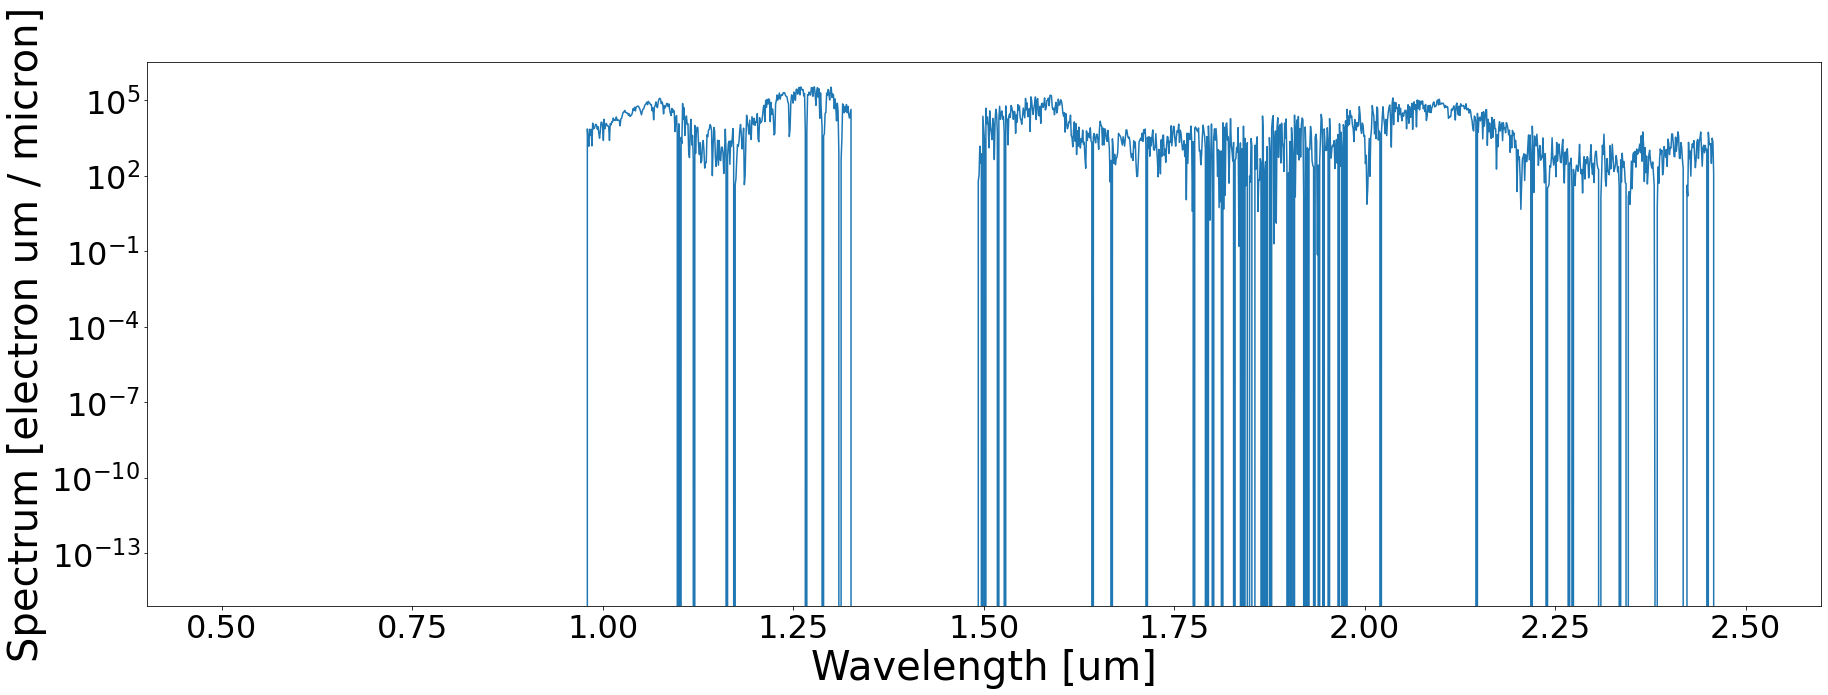

In [16]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
#plt.ylim(1e-4,2e2)

## Old Code

with old instrument throughput and telescope throughput, and old AO coupling.

In [17]:
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(TMT,modhis,host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                       post_processing_gain = 10,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False)

/Users/huihaoz/Downloads/psisim-kpic/psisim/observation.py:603: RuntimeWarning: invalid value encountered in sqrt
  photon_noise = np.sqrt(detector_spectrum.decompose().value + thermal_spectrum.decompose().value + speckle_noise.decompose().value) * u.electron


Text(0, 0.5, 'Spectrum [electron um / micron]')

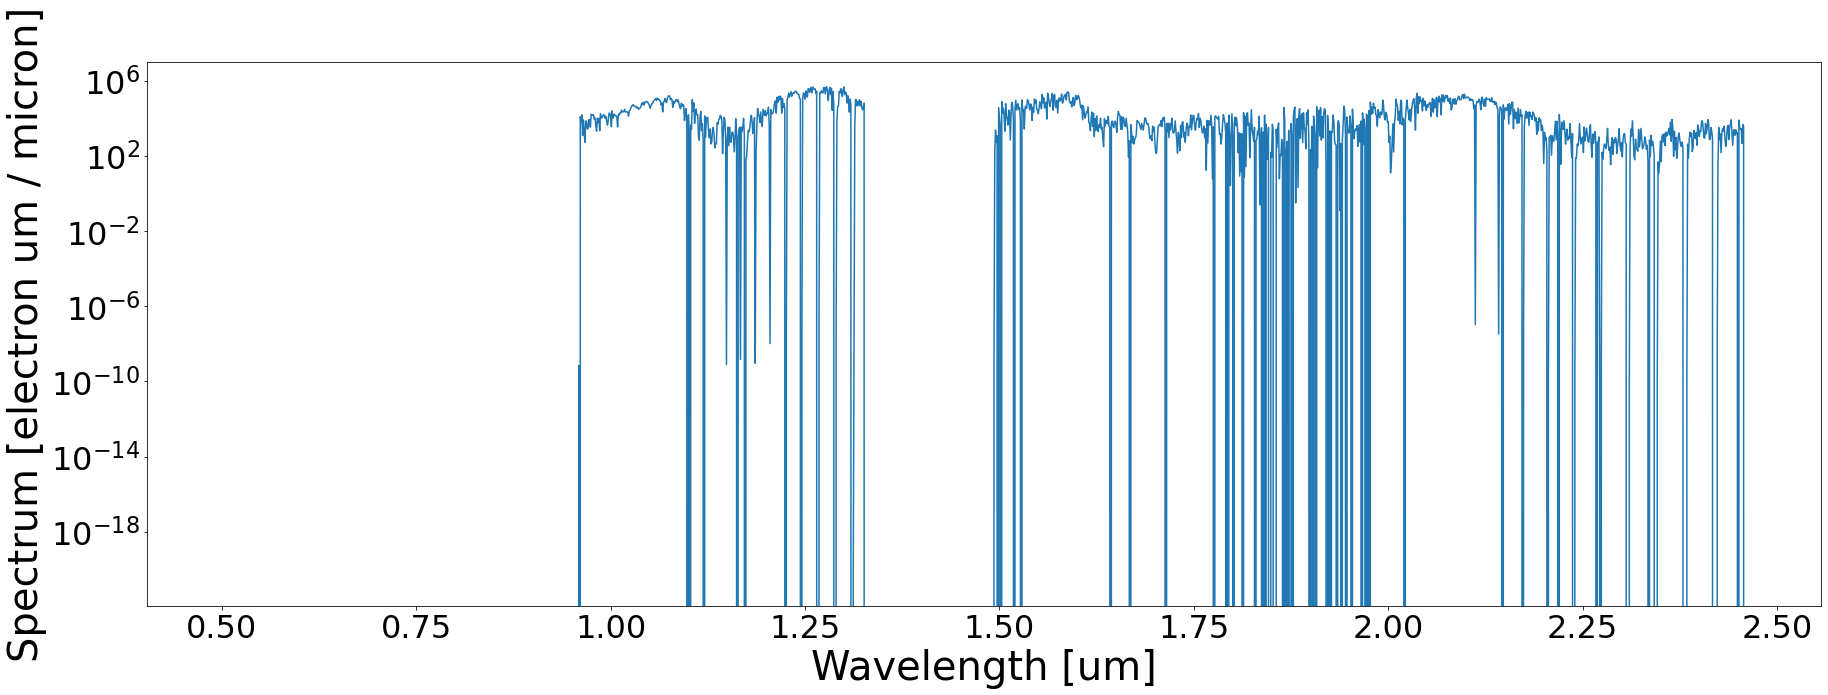

In [18]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
#plt.ylim(1e-4,2e2)

## single object observation

In [19]:
#detector_spectrum, total_noise, detector_thermal_flux,total_throughput_instrument
zx,zc,zv,zt = observation.simulate_observation_singletarget(TMT, modhis, host_spectrum.wvs, host_spectrum.spectrum,inject_noise = False, sky_on = False, post_processing_gain = 1, return_noise_components = False,apply_lsf = False, integrate_delta_wv = False)

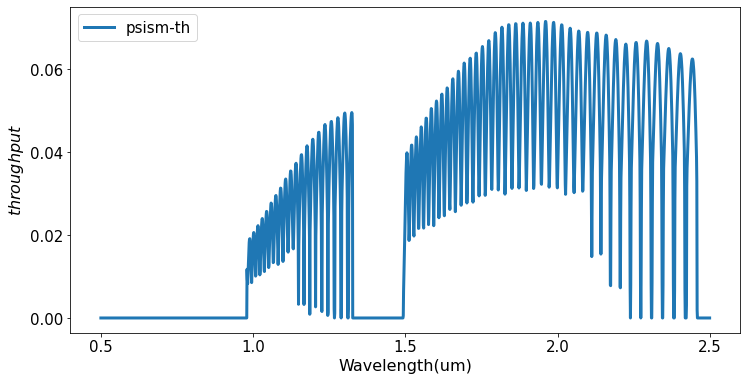

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(host_spectrum.wvs,zt,linewidth=3,color = '#1f77b4' ,label='psism-th')
plt.legend()
plt.xlabel("Wavelength(um)",fontdict={ 'size'   : 16})
plt.ylabel("$throughput$",fontdict={ 'size'   : 16})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(prop={'size': 15})

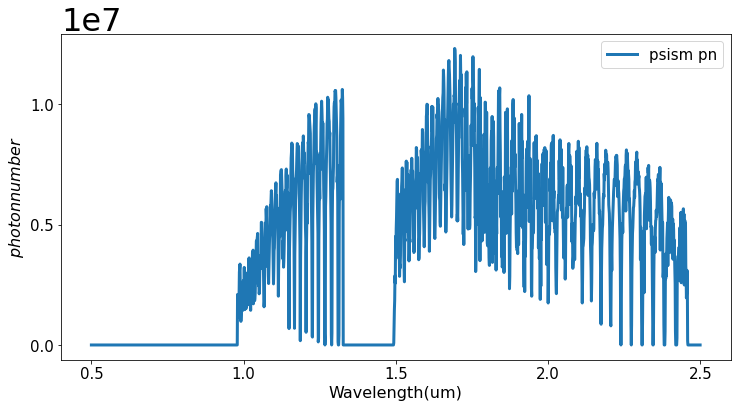

In [21]:
plt.figure(figsize=(12, 6))
#plt.plot(wl_um_check, tbd_tra1_erg_check/(1/ang2_1.to(u.steradian)),'-',color = '#1f77b4', label='Blackbody flux we simulated',linewidth=3)
#plt.plot(sim_x, sim_y,'o',color = '#ff7f0e', label ='Data come from SIMBAD')
plt.plot(host_spectrum.wvs,zx/0.95,linewidth=3,color = '#1f77b4' ,label='psism pn')
#plt.plot(so.inst.xtransmit/1000,so.inst.base_throughput * so.inst.coupling ,linewidth=3,color = 'red',label='specsim-th' )
plt.legend()
plt.xlabel("Wavelength(um)",fontdict={ 'size'   : 16})
plt.ylabel("$photon number$",fontdict={ 'size'   : 16})
#plt.xlim(0.9,5.6)
#plt.title("ELT-R150-TRA1")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(prop={'size': 15})

# HISPEC

Currently, coupling and AO data files are missing.

In [22]:
keck = telescope.Keck(path=path)
keck.airmass=1.0
keck.water_vapor=1.6
keck.seeing = keck.median_seeing

In [23]:
#Initialize a hispec object and set the current filter
hispec = instrument.hispec(telescope=keck)
hispec.set_current_filter("TwoMASS-K")

#Get the set of wavelengths based on the current instrument setup
wavelengths = np.arange(0.5,2.5,1e-3)*u.um 

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
hispec.set_observing_mode(3600*4,1,'TwoMASS-K', wavelengths,mode="off-axis") 




In [24]:
#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.50*u.dex(u.cm/ u.s**2),"StarTeff":2800*u.K,"StarZ":'-0.0',"StarAlpha":"0.0",
                   "StarRadialVelocity":0.001*u.km/u.s,
                    "StarVsini":0.001*u.km/u.s,
                    "StarLimbDarkening":0.001}

#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (path,'TwoMASS-K',14.0,filters,hispec.current_filter)

#Generate the spectrum! (Here we apply a doppler shift and rotationally broaden)
host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,hispec.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=hispec.current_dwvs)



In [25]:
obj_properties = {"StarLogg":3.25*u.dex(u.cm/ u.s**2),"StarTeff":700*u.K,"StarRadialVelocity":20*u.km/u.s,"StarVsini":10*u.km/u.s,
                  "StarLimbDarkening":0.9}

obj_user_params = (path,'TwoMASS-K',20,filters,hispec.current_filter)

obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,hispec.current_R,model="Sonora",
                                             user_params=obj_user_params,doppler_shift=True,broaden=True,
                                             delta_wv=hispec.current_dwvs)


In [26]:
# The angular separation of the companion, in milliarcsecond
host_properties['AngSep'] = 400 *u.mas

#Get the host star magnitude in the AO filter
#note that the band needs to be consistent with AO data file
host_properties["StarAOmag"] = spectrum.get_band_mag(family='Johnson',band='J',factor_0=f0,teff_s=2800*u.K,path=path)

#modhis.ao_mag = host_properties["StarAOmag"]
hispec.ao_mag = host_properties["StarAOmag"]

hispec.ao_ho_wfe, hispec.ao_tt_dynamic = spectrum.ao_coupling(instrument='hispec',ao_mode='LGS_100J_45',ao_filter='Johnson',ao_band_mag=hispec.ao_mag )

#modhis doesn't care about the spectral type, but we need to include the paramter
host_properties['StarSpT'] = None

In [27]:
hispec.ao_mag

14.98574280242744

In [28]:
hispec.ao_tt_dynamic

15.911150280760314

In [29]:
hispec.ao_ho_wfe

207.0

In [30]:
obj_spectrum.spectrum /= host_spectrum.spectrum

/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [31]:
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation_newao(keck,hispec,host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                       post_processing_gain = 10,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False)

Text(0, 0.5, 'Spectrum [electron um / micron]')

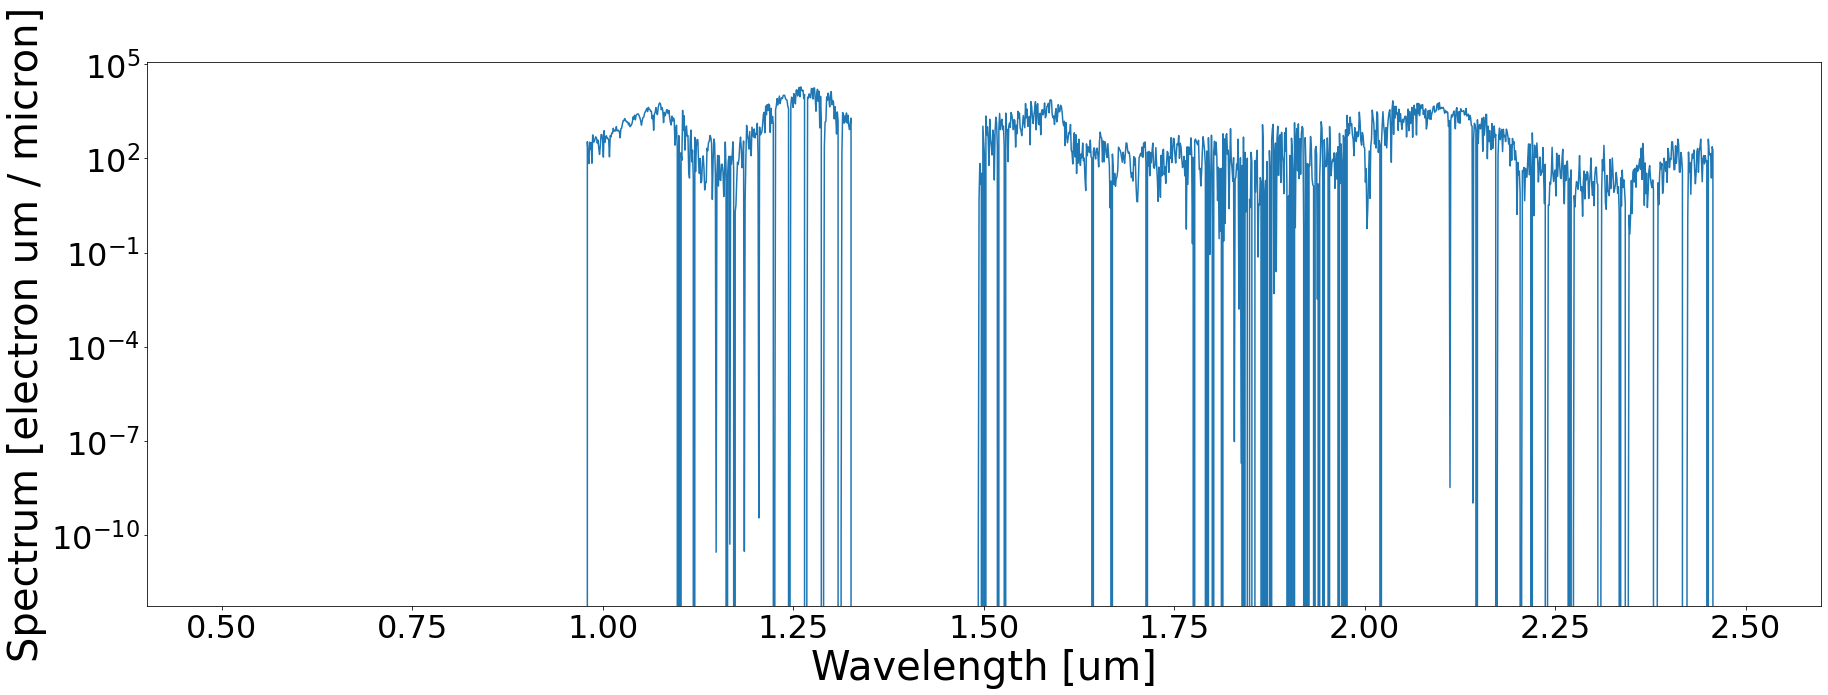

In [32]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
#plt.ylim(1e-4,2e2)